<a href="https://colab.research.google.com/github/medha-sagar/CSE547-BigDataForMachineLearning/blob/master/CSE547_HW2_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE547 - ALS

Adapted from Stanford's CS246

# Setup

In [0]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1Av3kW63qnjOgkVZKVum2yYih9UNwhlhM'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('artists.txt')

id='1-ribwL4DktJtxpuku2PpmtNGb_Ra6gh6'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('user-artists.txt')


Next, we import some of the common libraries needed for our task.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
import pandas as pd
from itertools import product

Let's initialize the Spark context.

In [0]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

sqlContext = SQLContext(sc)

In [0]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)


If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-04-28 23:03:27--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.3.89.125, 34.196.12.177, 3.227.142.238, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.3.89.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  14.0MB/s    in 0.9s    

2020-04-28 23:03:28 (14.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://e50c5bb7.ngrok.io


# Data Loading

In [0]:
user_artist = spark.read.option("sep", "\t").csv("user-artists.txt", header=True)
artists = spark.read.option("sep", "\t").csv("artists.txt", header=True)

In [0]:
user_artist = pd.read_csv("user-artists.txt", sep = "\t")
artists = pd.read_csv("artists.txt", sep = "\t")

# Create User Item Matrix

In [0]:
#Get unique artists and users
unique_users  = sorted(user_artist['userID'].unique())
unique_artists  = sorted(artists['artistID'].unique())

In [0]:
#Create All user-artist pairs
user_artist_pair = list(product(unique_users, unique_artists))
user_artist_pair_df = pd.DataFrame.from_records(user_artist_pair)

In [0]:
#Create User-Item Matrix 
user_artist_pair_df.columns = ['userID', 'artistID']
master = pd.merge(user_artist_pair_df, user_artist, how="left", on = ['userID', 'artistID'])

master = master.fillna(0)
master.shape

(5646000, 4)

# Calculate Sparsity Ratio

In [0]:
non_zero = master[master['interactions'] > 0]
sparsity_ratio = len(non_zero)/master[master["interactions"] == 0].shape[0]

62894

In [0]:
sparsity_ratio

0.011265055687640536

# Create Initial Pui Matrix

In [0]:
#Pivot the user matrix 
R = master.drop("preference", axis = 1)
R = R.pivot_table(index='userID', columns='artistID', values='interactions')
R.shape

(1882, 3000)

In [0]:
#Preference Matrix
P = R>0
P[P == True] = 1 
P[P == False] = 0
P = P.astype(np.float64, copy=False)

# ALS

In [0]:
#Error Function
def get_error(P, X, Y, R, lambda_):
  pred = np.dot(X, Y)
  #print("Min", np.min(pred))
  #print("Max", np.max(pred))
  return (np.sum(R * ((P - pred)** 2)) + lambda_*np.linalg.norm(X)**2 + lambda_*np.linalg.norm(Y)**2)

In [0]:
m,n  = R.shape

n_factors = 5 

lambda_ = 0.1

X = np.zeros((m,5))
X.fill(0.5)
Y = np.zeros((n,5))

n_iterations = 30


R = np.asarray(R)
P = np.asarray(P)
A = R.copy()
R = 1 + sparsity_ratio*A

In [0]:
cost_list = [get_error(P, X, Y, R, lambda_)]

for iterr in range(n_iterations):
  print(iterr)
  
  for i, Ri in enumerate(R.T):
    c_ui = Ri
    c_i = np.zeros((m,m))
    np.fill_diagonal(c_i, c_ui)
    
    ci_x = np.dot(c_i,X)
    xt_ci_x = np.dot(X.T, ci_x)
    lamb_eye = lambda_*(np.identity(n_factors))
    inv = np.linalg.inv(xt_ci_x + lamb_eye)
    inv_xt = np.dot(inv, X.T)
    inv_xt_ci = np.dot(np.dot(inv, X.T), c_i)
    sol = np.dot(inv_xt_ci, np.asarray(P[:,i]))
    
    Y[i,:] = sol
    

  for j, Rj in enumerate(R):
    c_ui = Rj
    c_i = np.zeros((n,n))
    np.fill_diagonal(c_i, c_ui)

    ci_y = np.dot(c_i,Y)
    yt_ci_y = np.dot(Y.T, ci_y)
    lamb_eye = lambda_*(np.identity(n_factors))
    inv = np.linalg.inv(yt_ci_y + lamb_eye)
    inv_yt = np.dot(inv, Y.T)
    inv_yt_ci = np.dot(np.dot(inv, Y.T), c_i)
    sol = np.dot(inv_yt_ci, np.asarray(P[j,:]))

    X[j,:] = sol
  
  cost_iter = get_error(P, X, Y.T, R, lambda_)
  cost_list.append(cost_iter)
  print("Error: ",cost_iter)
  print()


0
Min 5.673995736447579e-09
Max 2.047729935697474
Error:  320188.6502374511

1
Min 1.1348555989981374e-18
Max 1.850646040202348
Error:  313280.3594798447

2
Min -2.4267982116783515
Max 3.446891198289074
Error:  248869.16475375343

3
Min -1.3405593963528148
Max 2.0268275386507195
Error:  220698.33163265896

4
Min -1.2124110711484835
Max 2.0902076687645086
Error:  216009.06036632654

5
Min -1.198312006092525
Max 2.1887650335876674
Error:  213906.4014854579

6
Min -1.1493758582920608
Max 2.258338506265996
Error:  212458.80004766307

7
Min -1.1663753539069064
Max 2.2990385910396114
Error:  211271.58678442583

8
Min -1.1850737097057893
Max 2.3034180381434273
Error:  210276.85680129737

9
Min -1.2167393440483725
Max 2.2814811944828493
Error:  209456.26279705393

10
Min -1.2063991294516163
Max 2.2651150182564352
Error:  208800.24586485536

11
Min -1.210698755068811
Max 2.280513398910855
Error:  208306.61550009937

12
Min -1.2115616472779214
Max 2.2756341078366304
Error:  207954.74281172024

1

In [0]:
#Final Preference Matrix - Predicted 
pred = np.dot(X, Y.T)

In [0]:
pred[30,83]

0.5307456614650116

In [0]:
df = pd.DataFrame(pred)
df.to_csv('pred_original.csv')

# Plotting Cost

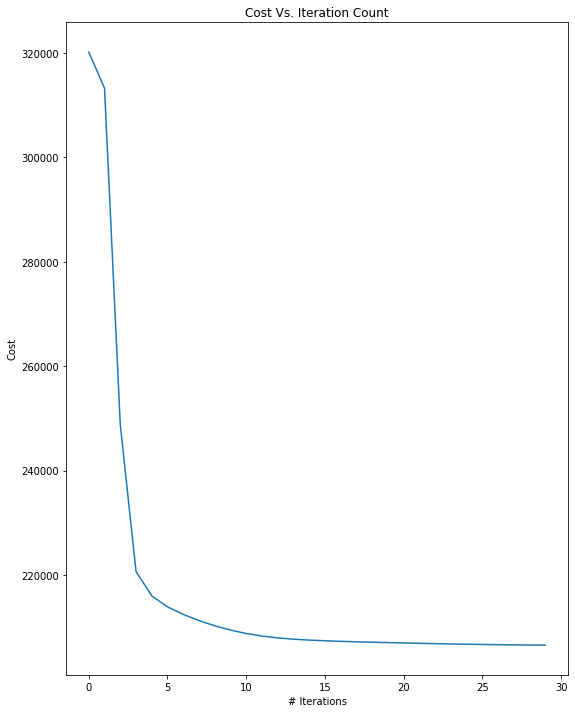

In [0]:
plt.figure(figsize=(9,12))
plt.plot(cost_list)
plt.title("Cost Vs. Iteration Count")
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.savefig('fig2.png', dpi = 300)
plt.show()


In [0]:
MSE_List

[320188.6502374511,
 313280.3594798447,
 248869.16475375343,
 220698.33163265896,
 216009.06036632654,
 213906.4014854579,
 212458.80004766307,
 211271.58678442583,
 210276.85680129737,
 209456.26279705393,
 208800.24586485536,
 208306.61550009937,
 207954.74281172024,
 207708.70405198517,
 207533.6884367042,
 207402.032910541,
 207296.41870430447,
 207206.90755129492,
 207127.309899773,
 207053.4042526632,
 206982.86032112112,
 206915.6951182982,
 206852.98626553454,
 206795.3242289351,
 206743.08072089346,
 206696.7161688719,
 206656.51307555908,
 206622.06135107004,
 206592.31853963537,
 206566.19524494218]